In [5]:
import pyro
import pyro.distributions as dist
import pandas as pd

In [45]:
def model(size,
          obs_std=None,
          obs_y=None
         ):
    std = pyro.sample('std', dist.Gamma(1,1), obs=obs_std)
    with pyro.plate('data', size):
        y = pyro.sample('y', dist.Normal(0,std), obs=obs_y)
    return y, std

In [66]:
y_gt, std_gt = model(100, obs_std=1)

/Users/gw/miniconda2/envs/phys_aware_cryoem_202207/lib/python3.7/site-packages/pyro/primitives.py:139: RuntimeWarning: trying to observe a value outside of inference at std
  RuntimeWarning,


In [125]:
# ((y_gt - y_gt.mean())**2).mean(), y_gt.std()

<AxesSubplot:ylabel='Frequency'>

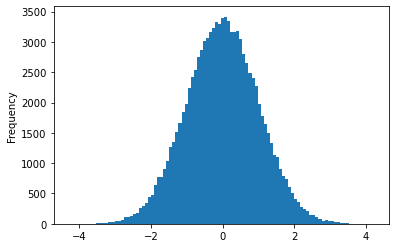

In [30]:
pd.Series(y_gt.numpy()).plot.hist(bins=100)

In [ ]:
y_test, std_test = model(100000, obs_std=1)

In [40]:
std_test

1

<AxesSubplot:ylabel='Frequency'>

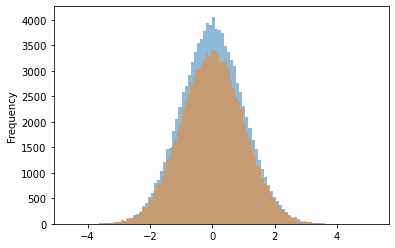

In [39]:
pd.Series(y_test.numpy()).plot.hist(bins=100, alpha=0.5)
pd.Series(y_gt.numpy()).plot.hist(bins=100, alpha=0.5)

# ABC

In [110]:
def abc(n_trials = 10, eps = 0.2):
    y_trials = []
    std_trials = []
    l2_dist_trials = []
    accept_trials = []
    for trial in range(n_trials):# for num_trials
        # draw std from prior, and y from likelihood (i.e. draw std,y from joint distribution)
        y_trial, std_trial = model(100, obs_std=None)
        # compare y to y0 to get distance
        sample_std_gt = y_gt.std()
        sample_std_trial = y_trial.std()
        l2_dist = (sample_std_gt - sample_std_trial).pow(2).sum()
        # accept or reject by epsilon criterion
        accept = l2_dist < eps
        y_trials.append(y_trial.tolist())
        l2_dist_trials.append(l2_dist.item())
        std_trials.append(std_trial.item())
        accept_trials.append(accept.item())
    # return samples, l2_dist
    return y_trials, l2_dist_trials, std_trials, accept_trials

y_trials, l2_dist_trials, std_trials, accept_trials = abc(n_trials=1000,eps=0.1)

<AxesSubplot:ylabel='Frequency'>

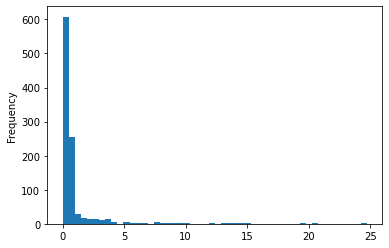

In [111]:
pd.Series(l2_dist_trials).plot.hist(bins=50)

<AxesSubplot:ylabel='Frequency'>

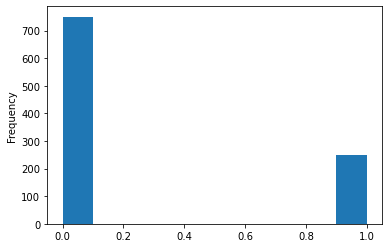

In [112]:
pd.Series(accept_trials).astype(int).plot.hist()

In [113]:
results_df = pd.DataFrame({'std': std_trials, 'accept':accept_trials})

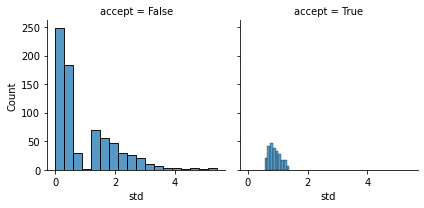

In [114]:
import seaborn as sns
g = sns.FacetGrid(results_df, col="accept")
g.map_dataframe(sns.histplot, x="std")

In [115]:
idx = results_df['accept'] == True
results_df[idx]

,std,accept
5,1.146343,True
12,0.748912,True
21,0.910077,True
24,0.639706,True
27,0.999010,True
...,...,...
974,0.714604,True
981,0.798420,True
982,0.705398,True
988,0.796635,True
